Each sample in the train and test set has the following information:

- The text of a tweet
- A keyword from that tweet (although this may be blank!)
- The location the tweet was sent from (may also be blank)

We are predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.


More details about the competition here:
https://www.kaggle.com/c/nlp-getting-started

In [1]:
from IPython.core.debugger import set_trace

%load_ext nb_black

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time

plt.style.use(style="seaborn")
%matplotlib inline

<IPython.core.display.Javascript object>

In [2]:
movies = pd.read_csv(
    "https://data-bootcamp-ztc.s3.amazonaws.com/movies_complete_cleaned.csv"
)

awards = pd.read_csv(
    "https://data-bootcamp-ztc.s3.amazonaws.com/parsed_awards_table.csv"
)

movies_sel = movies[["name", "plot"]]

awards_sel = awards[["name", "oscar wins and nominations"]]

df = pd.merge(movies_sel, awards_sel, how="right", on="name")

df["oscar_nom"] = [1 if x != 0 else 0 for x in df["oscar wins and nominations"]]

df = df[["name", "plot", "oscar_nom"]]

df["plot"].fillna("", inplace=True)

df.head()

,name,plot,oscar_nom
0,Gold,"With the sudden death of his father, fourth-ge...",0
1,The Choice,"In a small coastal town, the veterinarian Trav...",0
2,Middle School: The Worst Years of My Life,Imaginative quiet teenager Rafe Katchadorian i...,0
3,Midnight Special,Alton Meyer is a boy unlike any other in the w...,0
4,A Monster Calls,The monster does not come walking often. This ...,0


<IPython.core.display.Javascript object>

### N-gram analysis

Note: zip() in conjunction with the * operator can be used to unzip a list

In [3]:
from nltk.corpus import stopwords


def generate_ngrams(text, n_gram=1, stop=True):
    """
    Simple n-gram generator.
    """
    stop = set(stopwords.words("english")) if stop else {}

    token = [
        token for token in text.lower().split(" ") if token != "" if token not in stop
    ]
    z = zip(*[token[i:] for i in range(n_gram)])
    ngrams = [" ".join(ngram) for ngram in z]

    return ngrams

<IPython.core.display.Javascript object>

#### Create unigrams

In [4]:
from collections import defaultdict

<IPython.core.display.Javascript object>

In our case when a new word is encountered and is missing from the mapping, the default_factory function calls int() to supply a default count of zero and then, the increment operation builds up the count. 

Therefore, the default_factory int assign makes the defaultdict useful for counting.

In [5]:
oscar_unigrams = defaultdict(int)
nonoscar_unigrams = defaultdict(int)

<IPython.core.display.Javascript object>

In [6]:
for text in df[df["oscar_nom"] == 1]["plot"]:
    for word in generate_ngrams(text):
        oscar_unigrams[word] += 1

for text in df[df["oscar_nom"] == 0]["plot"]:
    for word in generate_ngrams(text):
        nonoscar_unigrams[word] += 1

<IPython.core.display.Javascript object>

In [7]:
df_oscar_unigrams = pd.DataFrame(
    sorted(oscar_unigrams.items(), key=lambda x: x[1], reverse=True)
)
df_nonoscar_unigrams = pd.DataFrame(
    sorted(nonoscar_unigrams.items(), key=lambda x: x[1], reverse=True)
)


<IPython.core.display.Javascript object>

In [8]:
sorted(oscar_unigrams.items(), key=lambda x: x[1], reverse=True)[:10]

[('one', 289),
 ('life', 269),
 ('new', 255),
 ('young', 187),
 ('two', 177),
 ('family', 155),
 ('man', 151),
 ('-', 148),
 ('love', 146),
 ('find', 142)]

<IPython.core.display.Javascript object>

In [9]:
sorted(nonoscar_unigrams.items(), key=lambda x: x[1], reverse=True)[:10]

[('one', 1416),
 ('new', 1190),
 ('two', 976),
 ('get', 934),
 ('life', 931),
 ('find', 868),
 ('young', 831),
 ('-', 752),
 ('man', 696),
 ('finds', 683)]

<IPython.core.display.Javascript object>

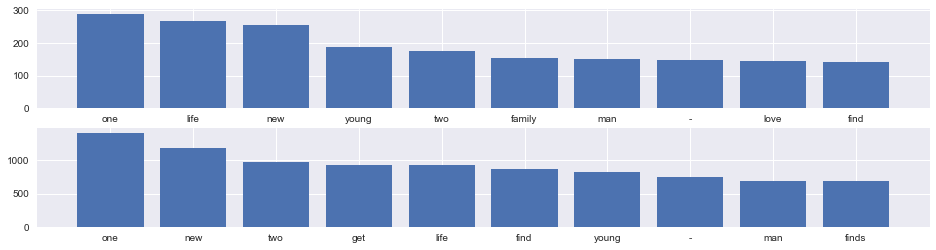

<IPython.core.display.Javascript object>

In [10]:
d1 = df_oscar_unigrams[0][:10]
d2 = df_oscar_unigrams[1][:10]

nd1 = df_nonoscar_unigrams[0][:10]
nd2 = df_nonoscar_unigrams[1][:10]

plt.figure(1, figsize=(16, 4))
plt.subplot(2, 1, 1)
_ = plt.bar(d1, d2)

plt.subplot(2, 1, 2)
_ = plt.bar(nd1, nd2)

Based on the plot above we can see that most common shared unigrams are punctuation and stopwords so it's important to clean them out.

Regarding the context, even from the unigrams we can see that we get a lot of context regarding whether the text refers to a disaster or not. 

#### Create bigrams

In [11]:
import string


def remove_punct(text):
    table = str.maketrans("", "", string.punctuation)
    return text.translate(table)


df["plot"] = [remove_punct(x) for x in df["plot"]]

from nltk.corpus import stopwords

stop = set(stopwords.words("english"))


def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]

    return " ".join(text)


df["plot"] = [remove_stopwords(x) for x in df["plot"]]

oscar_bigrams = defaultdict(int)
nonoscar_bigrams = defaultdict(int)

for text in df[df["oscar_nom"] == 1]["plot"]:
    for word in generate_ngrams(text, n_gram=2):
        oscar_bigrams[word] += 1

for text in df[df["oscar_nom"] == 0]["plot"]:
    for word in generate_ngrams(text, n_gram=2):
        nonoscar_bigrams[word] += 1

df_oscar_bigrams = pd.DataFrame(sorted(oscar_bigrams.items(), key=lambda x: x[1])[::-1])
df_nonoscar_bigrams = pd.DataFrame(
    sorted(nonoscar_bigrams.items(), key=lambda x: x[1])[::-1]
)

<IPython.core.display.Javascript object>

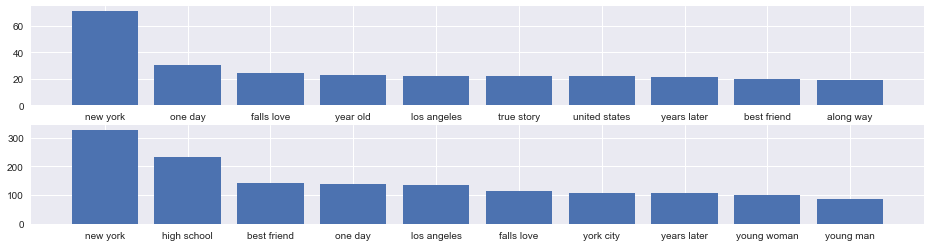

<IPython.core.display.Javascript object>

In [12]:
d1 = df_oscar_bigrams[0][:10]
d2 = df_oscar_bigrams[1][:10]

nd1 = df_nonoscar_bigrams[0][:10]
nd2 = df_nonoscar_bigrams[1][:10]

plt.figure(1, figsize=(16, 4))
plt.subplot(2, 1, 1)
_ = plt.bar(d1, d2)

plt.subplot(2, 1, 2)
_ = plt.bar(nd1, nd2)

The plot above shows that bigrams give a lot of context to the type of text with regard to whether it's a disaster or not. If we clean the punctuation and stopwords and urls we should get a better understanding.

Check the most common bigrams in a whole corpus.

In [13]:
from sklearn.feature_extraction.text import CountVectorizer


def get_top_text_ngrams(corpus, ngrams=(1, 1), nr=None):
    """
    Creates a bag of ngrams and counts ngram frequency.

    Returns a sorted list of tuples: (ngram, count)
    """
    vec = CountVectorizer(ngram_range=ngrams).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:nr]

<IPython.core.display.Javascript object>

In [14]:
top_text_bigrams = get_top_text_ngrams(df["plot"], ngrams=(2, 2), nr=10)

<IPython.core.display.Javascript object>

In [15]:
top_text_bigrams

[('new york', 399),
 ('high school', 248),
 ('one day', 167),
 ('best friend', 162),
 ('los angeles', 158),
 ('falls love', 139),
 ('years later', 128),
 ('york city', 120),
 ('young woman', 115),
 ('young man', 106)]

<IPython.core.display.Javascript object>

<BarContainer object of 10 artists>

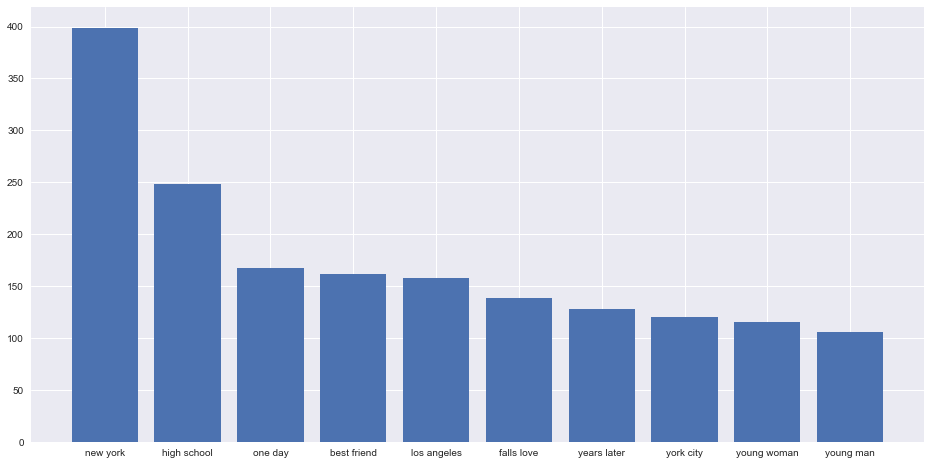

<IPython.core.display.Javascript object>

In [16]:
x, y = zip(*top_text_bigrams)
plt.figure(1, figsize=(16, 8))
plt.subplot(1, 1, 1)
plt.bar(x, y)

In [28]:
top_text_bigrams_and_trigrams = get_top_text_ngrams(df["plot"], ngrams=(2, 3), nr=10)

[('new york', 399),
 ('high school', 248),
 ('one day', 167),
 ('best friend', 162),
 ('los angeles', 158),
 ('falls love', 139),
 ('years later', 128),
 ('york city', 120),
 ('new york city', 120),
 ('young woman', 115)]

<IPython.core.display.Javascript object>

In [29]:
top_text_trigrams = get_top_text_ngrams(df["plot"], ngrams=(3, 3), nr=10)

<IPython.core.display.Javascript object>

In [30]:
top_text_trigrams

[('new york city', 120),
 ('world war ii', 46),
 ('based true story', 37),
 ('must find way', 21),
 ('high school student', 19),
 ('president united states', 17),
 ('things get worse', 13),
 ('find way get', 13),
 ('year old son', 13),
 ('high school senior', 12)]

<IPython.core.display.Javascript object>

In [33]:
top_text_trigrams_oscars = get_top_text_ngrams(
    df[df["oscar_nom"] == 1]["plot"], ngrams=(2, 3), nr=10
)
top_text_trigrams_oscars

[('new york', 71),
 ('one day', 30),
 ('falls love', 24),
 ('year old', 23),
 ('united states', 22),
 ('true story', 22),
 ('los angeles', 22),
 ('years later', 21),
 ('best friend', 20),
 ('young man', 19)]

<IPython.core.display.Javascript object>

In [34]:
top_text_trigrams_nonoscars = get_top_text_ngrams(
    df[df["oscar_nom"] == 0]["plot"], ngrams=(2, 3), nr=10
)
top_text_trigrams_nonoscars

[('new york', 328),
 ('high school', 234),
 ('best friend', 142),
 ('one day', 137),
 ('los angeles', 136),
 ('falls love', 115),
 ('years later', 107),
 ('york city', 107),
 ('new york city', 107),
 ('young woman', 102)]

<IPython.core.display.Javascript object>